In [1]:


import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import math
from math import log
import sympy as sym



## Problem 1
For a one dimensional 2-class problem with 2 actions a1, a2 , (a1: choose omega1; a2 choose w2). We assume P(omega1) = 3/5, P(w2) = 2/5, conditional densities p(x|w1) ~ N(0, 1) and p(x|w2) ~ N(2, 4),
where N(µ, σ2) is Normal distribution, µ is mean and σ2 is variance.

In [2]:

def get_norm_distribution(mu, std, x):
    '''Given mean and standard deviation, outputs the normal distribution for x,
    which can be a vector or a specific value.'''

    # get normal distribution for given mean and variance
    N = stats.norm(mu, np.sqrt(std))
    # return partial dist. vector from N(mu, std. dev.)
    norm_dist = N.pdf(x)

    return norm_dist

def plot_norm_dist():
    plt.xlim(-10, 10)
    plt.ylim(0,0.5)
    plt.title('Likelihood Functions for All Classes')
    plt.xlabel('x')
    plt.ylabel('Probability, P')

    # plot likelihood for each class
    plt.plot(x, get_norm_distribution(0, 1, x))
    plt.plot(x, get_norm_distribution(2, 4, x))
    plt.show()

    # calculate at specific point, x=5
    v1 = get_norm_distribution(0, 1, 5)
    v2 = get_norm_distribution(2, 4, 5)

    print(f' Class likelihood when x = {5}:\n',
          f'Class 1, N(0,1) = {v1:.3}\n',              # 1.4867195147342979e-06
          f'Class 2, N(2,4) = {v2:.3}')                # 0.0648

def get_evidence_distribution(x,norm_dist,P):

    lst = [[c*b for c in a] for a,b in zip(norm_dist,P)]

    return sum(np.array(lst),0)

def plot_evidence(norm_dist):
    plt.xlim(-10, 10)
    plt.ylim(0,0.3)

    plt.title('Evidence Distribution')
    plt.xlabel('x')
    plt.ylabel('Probability, P')

    return plt.plot(x, get_evidence_distribution(x,norm_dist,P))



### 1.1: Sketch the likelihood function for each class. Calculate the likelihood value for each class if x = 5.

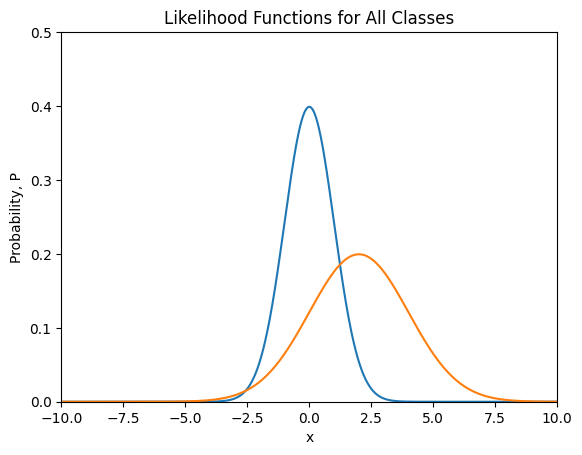

 Class likelihood when x = 5:
 Class 1, N(0,1) = 1.49e-06
 Class 2, N(2,4) = 0.0648


In [3]:

step = 0.01
x = np.linspace(-10.0, 10.0, int(20/step)+1)

plot_norm_dist()

### 1.2: Sketch the evidence distribution. Calculate the evidence value if x=5.

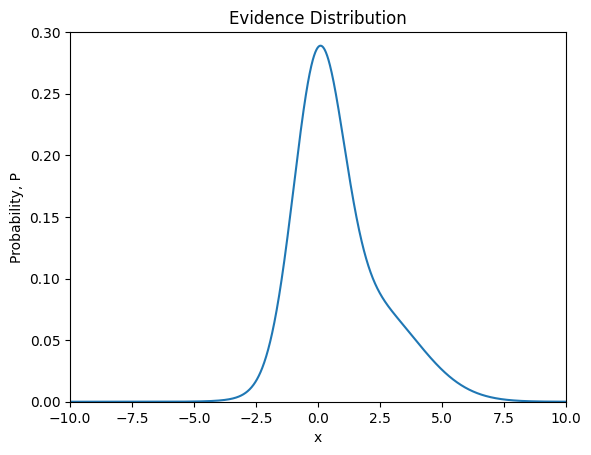

Evidence value when x = 5:
0.0259


In [4]:

# prior probabilities
P = [3/5, 2/5]

# normal distribution vectors
norm_dist = [get_norm_distribution(0, 1, x), get_norm_distribution(2, 4, x)]

plot_evidence(norm_dist)
plt.show()

# calculate value at x=5
ev_calc = [get_norm_distribution(0, 1, 5), get_norm_distribution(2, 4, 5)]
ev_val = ev_calc[0]*P[0]+ev_calc[1]*P[1]

print(f'Evidence value when x = {5}:\n{ev_val:.4}')


### 1.3: Sketch the posterior probability function for each class. Calculate the posterior probability value for each class if x=5.

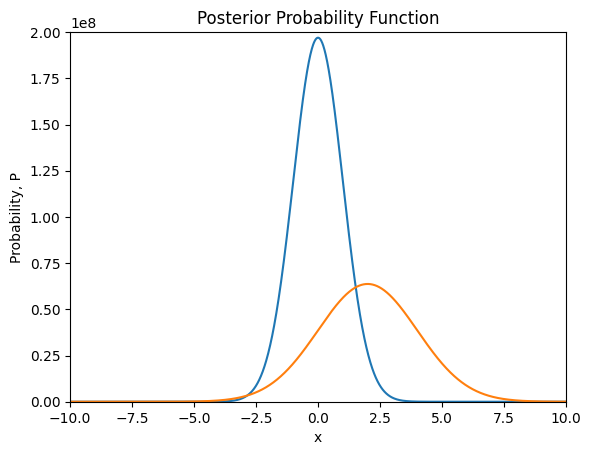

 Class posterior probability when x = 5:
 Class 1, N(0,1) = 3.44e-05
 Class 2, N(2,4) = 1.0


In [5]:

plt.xlim(-10, 10)
plt.ylim(0,2e8)
#
plt.title('Posterior Probability Function')
plt.xlabel('x')
plt.ylabel('Probability, P')

evidence = get_evidence_distribution(x,norm_dist,P)
prob = [[c*b for c in a] for a,b in zip(norm_dist,P)]
post_prob = [a/b for a,b in zip(prob, get_evidence_distribution(x,norm_dist,P))]

plt.plot(x, post_prob[0])
plt.plot(x, post_prob[1])
plt.show()

prob1 = get_norm_distribution(0, 1, 5)*P[0]/ev_val
prob2 = get_norm_distribution(2, 4, 5)*P[1]/ev_val

print(f' Class posterior probability when x = {5}:\n',
      f'Class 1, N(0,1) = {prob1:.3}\n',
      f'Class 2, N(2,4) = {prob2:.3}')



### 1.4: Sketch the likelihood ratio function (ref. Figure 2.3). Calculate the likelihood ratio value if x=5.

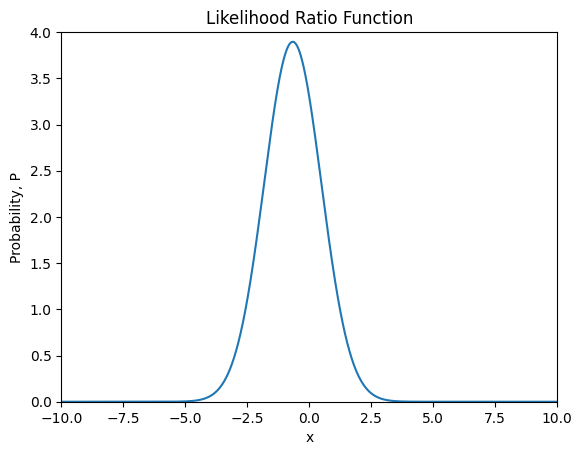

Likelihood ratio when x = 5:
2.296e-05


In [6]:

plt.xlim(-10, 10)
plt.ylim(0,4)

plt.title('Likelihood Ratio Function')
plt.xlabel('x')
plt.ylabel('Probability, P')

likelihood = get_norm_distribution(0, 1, x)/get_norm_distribution(2, 4, x)
plt.plot(x,likelihood)
plt.show()

like_val = get_norm_distribution(0, 1, 5)/get_norm_distribution(2, 4, 5)
print(f'Likelihood ratio when x = {5}:\n{like_val:.4}')



### 1.5: Calculate the likelihood ratio threshold for zero-one loss function, i.e. maximum posterior classification.

In [7]:

theta_zero_one = P[1]/P[0]
risk = [[0,4],[2,0]]

theta_zero_one


0.6666666666666667

### 1.6: Calculate the likelihood ratio threshold for the following risk matrix: [[0,4],[2,0]]

In [8]:
theta_risk_mat = (risk[0][1] - risk[1][1])/(risk[1][0] - risk[0][0])*theta_zero_one

theta_risk_mat

1.3333333333333335

### 1.7: Following 1.6, sketch the Bayes risk (conditional risk R(αi|x) associated with the action αi according to observation x) as a function of x. Calculate the Bayes risk value if x=5.

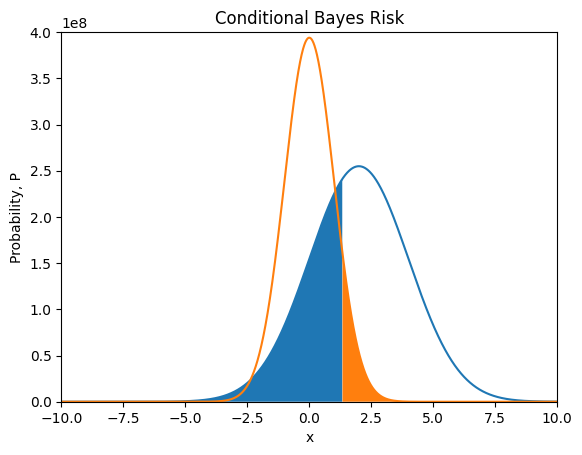

Bayes Risk when x = 5:
2.144e+06


In [9]:

plt.xlim(-10, 10)
plt.ylim(0,4e8)

plt.title('Conditional Bayes Risk')
plt.xlabel('x')
plt.ylabel('Probability, P')

R1 = np.sum([a*b for a,b in zip(post_prob, risk[0])], 0)
R2 = np.sum([a*b for a,b in zip(post_prob, risk[1])], 0)

plt.plot(x,R1)
plt.plot(x,R2)
plt.fill_between(x,R1, where=(x<theta_risk_mat))
plt.fill_between(x,R2, where=(x>theta_risk_mat))
plt.show()

bayes_df = pd.DataFrame({'R1':R1, 'R2':R2}, index=x)
bayes = bayes_df['R1'][5]*ev_val + bayes_df['R2'][5]*ev_val

print(f'Bayes Risk when x = {5}:\n{bayes:.4}')


## Problem 2

### 2.1: Calculate the decision boundary.

In [10]:


mu = np.array([[0,0],[2,2]])
sigma = np.array([[[1,0],[0,2]],[[1,1],[1,2]]])

P_2 = [0.25, 0.75]

sig_inv =  np.array([np.linalg.inv(np.matrix(s)) for s in sigma])

# calculate variables for arbitrary sigma; quadratic discriminant fxn
W = -0.5*sig_inv
w = np.array([sig_inv[i].dot(x) for i,x in enumerate(mu)])

det = [(s[0][0]*s[1][1]-s[1][0]*s[0][1])/s[0][0] for s in sigma]

w0 = [-0.5*w[i].dot(mu[i].T)-0.5*log(det[i])+log(x) for i,x in enumerate(P_2)]


In [11]:

x1 = sym.Symbol('x1')
x2 = sym.Symbol('x2')

def get_gix(x_v):
    gx = [np.transpose(x_v).dot(W[i]).dot(x_v) + np.transpose(w[i]).dot(x_v) + c for i,c in enumerate(w0)]
    return gx

boundary = sym.simplify(get_gix([x1,x2])[0]-get_gix([x1,x2])[1])

# when g1 = g2 --> g1-g2 = 0
boundary


0.5*x1**2 - 1.0*x1*x2 - 2.0*x1 + 0.25*x2**2 + 0.554814121051918

### 2.2: Calculate the Bhattacharyya error bound.

In [12]:

mu1, mu2 = np.array(mu[0]), np.array(mu[1])
sigma1, sigma2 = np.array(sigma[0]), np.array(sigma[1])

k1 = (1/8)*np.transpose(mu2-mu1)
k2 = np.linalg.inv((sigma1+sigma2)/2).dot((mu2-mu1))

n = (sigma1+sigma2)/2
d = np.sqrt(det[0]*det[1])
k3 = 0.5*np.log(((n[0][0]*n[1][1]-n[1][0]*n[0][1])/n[0][0])/d)

k = k1.dot(k2)+k3
P_error = np.sqrt(P_2[0]*P_2[1])*math.e**(-1*k)

print(f'Bhattacharyya error bound: P(error) <= {P_error:.4}')


Bhattacharyya error bound: P(error) <= 0.2198
